### ISS VSE CA2 Part2

#### By: Kenneth Goh (A0198544N), Raymond Ng (A0198543R), Tan Heng Han (A0198502B)

In [456]:
import cv2
import os
import math
import time
from collections import Counter
from itertools import repeat
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from glob import glob
from tqdm import tqdm

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv3D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import MaxPooling3D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Add
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import he_normal
from tensorflow.keras.regularizers import l2

import sklearn.metrics as metrics
from sklearn.preprocessing import LabelEncoder

### Config

In [457]:
# Config
modelInWidth = 368
modelInHeight = 368
TEST_SIZE = 0.2
BATCH_SIZE = 2
EPOCH = 200

### Load and slice videos for training
Slice training videos into 5hz frames for model input
Data set:
1. Push up videos
2. Mixture of non push up videos

In [458]:
# Get filenames and labels for data
labels = ['PushUps', 'NotPushUps']
data_path = 'data/'
files = pd.DataFrame()
filenames = []
for lbl in labels:
    filename = np.array(glob(os.path.join(data_path, lbl) + '/*.avi'))
    filenames.append(filename)

files['video_name'] = [item for sublist in filenames for item in sublist]
files.head()

,video_name
0,data/PushUps\v_PushUps_g01_c01.avi
1,data/NotPushUps\v_PullUps_g02_c01.avi


In [459]:
# Slice and store the frames from training videos
for i in tqdm(range(files.shape[0])):
    count = 0
    videoFile = files['video_name'][i]
    cap = cv2.VideoCapture(videoFile)   # capturing the video from the given path
    frameRate = cap.get(5) #frame rate
    while(cap.isOpened()):
        frameId = cap.get(1) #current frame number
        ret, frame = cap.read()
        if (ret != True):
            break
        if (frameId % 2 == 0):
            # storing the frames in a new folder named train_1
            filename ='data/images/' + videoFile.split('\\')[1] +"_frame%d.jpg" % count;count+=1
            cv2.imwrite(filename, frame)
    cap.release()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.85it/s]


In [460]:
%%time
# Get filepath of all sliced images and read all images
dataset_frame_path = 'data/images'
frame_filenames = glob(dataset_frame_path + '/*.jpg')

frames_n_labels = pd.DataFrame()

frame_list = []
label_list = []
for idx in tqdm(range(len(frame_filenames))):
    frame_list.append(cv2.imread(frame_filenames[idx]))
    label = frame_filenames[idx].split('_')[1]
    if label not in labels:
        label = labels[1] # Assign all non-pushup
    label_list.append(label)
frames_n_labels['frame'] = frame_list
frames_n_labels['label'] = np.vstack(label_list)
frames_n_labels.info

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 89/89 [00:00<00:00, 193.79it/s]


Wall time: 468 ms


<bound method DataFrame.info of                                                 frame       label
0   [[[1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], ...  NotPushUps
1   [[[1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], ...  NotPushUps
2   [[[1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], ...  NotPushUps
3   [[[1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], ...  NotPushUps
4   [[[1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], ...  NotPushUps
..                                                ...         ...
84  [[[7, 75, 140], [9, 78, 141], [8, 77, 140], [8...     PushUps
85  [[[7, 75, 142], [11, 79, 144], [7, 78, 142], [...     PushUps
86  [[[7, 76, 139], [10, 80, 140], [8, 78, 138], [...     PushUps
87  [[[6, 76, 136], [10, 80, 139], [8, 79, 136], [...     PushUps
88  [[[6, 76, 136], [10, 80, 139], [8, 79, 136], [...     PushUps

[89 rows x 2 columns]>

Text(0.5, 1.0, 'Frame Distribution')

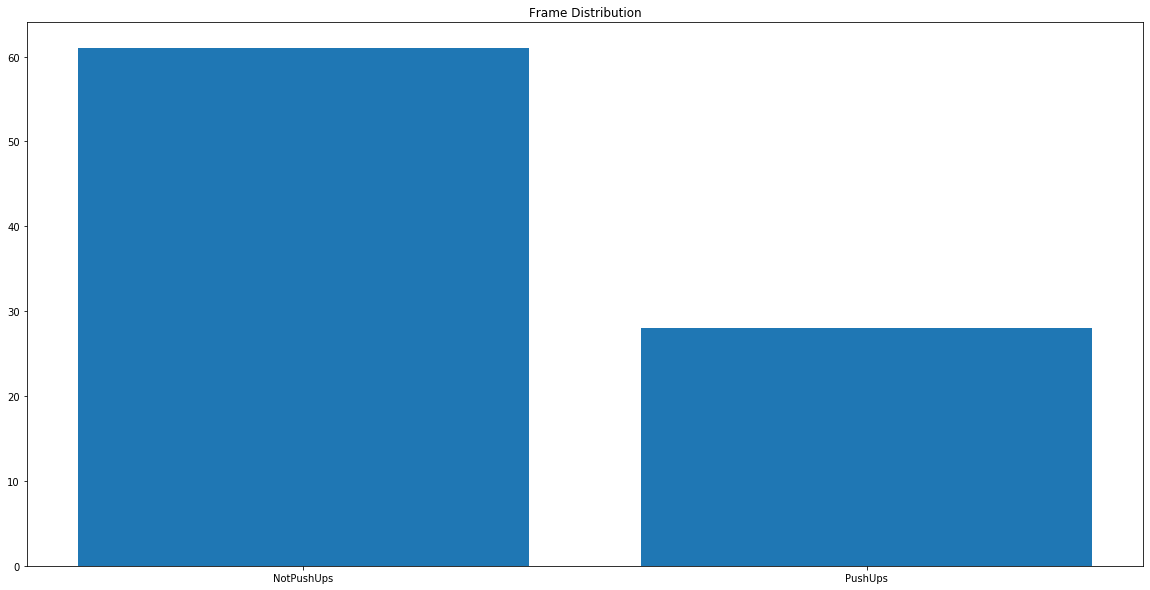

In [461]:
label_count = Counter(frames_n_labels['label'])
plt.figure(figsize=(20,10))
plt.bar(label_count.keys(), label_count.values())
plt.title('Frame Distribution')

### Load OpenPose models

#### Instructions to get openpose models
1. Clone https://github.com/CMU-Perceptual-Computing-Lab/openpose
2. Open a console and run **openpose/models/getModels.bat**
3. Copy contents from **openpose/models/pose/coco** to **Model/coco**

In [462]:
PROTO_FILE = 'Model/coco/pose_deploy_linevec.prototxt'
WEIGHTS_FILE = 'Model/coco/pose_iter_440000.caffemodel'
BODY_PARTS = { "Nose": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist": 4,
               "LShoulder": 5, "LElbow": 6, "LWrist": 7, "RHip": 8, "RKnee": 9,
               "RAnkle": 10, "LHip": 11, "LKnee": 12, "LAnkle": 13, "REye": 14,
               "LEye": 15, "REar": 16, "LEar": 17, "Background": 18 }
POSE_PAIRS = [ ["Neck", "RShoulder"], ["Neck", "LShoulder"], ["RShoulder", "RElbow"],
               ["RElbow", "RWrist"], ["LShoulder", "LElbow"], ["LElbow", "LWrist"],
               ["Neck", "RHip"], ["RHip", "RKnee"], ["RKnee", "RAnkle"], ["Neck", "LHip"],
               ["LHip", "LKnee"], ["LKnee", "LAnkle"], ["Neck", "Nose"], ["Nose", "REye"],
               ["REye", "REar"], ["Nose", "LEye"], ["LEye", "LEar"] ]

In [463]:
# Load openpose model via Opencv
try:
    net = cv2.dnn.readNetFromCaffe(PROTO_FILE, WEIGHTS_FILE)
except:
    raise Exception('Error reading model, check model proto and weights file.')

### Run Openpose inference for each frame
Save heat maps for training

In [464]:
%%time
netout = []
for idx in tqdm(range(len(frames_n_labels['frame']))):
    currFrame = frames_n_labels['frame'][idx]
    frameWidth = currFrame.shape[1]
    frameHeight = currFrame.shape[0]
    inBlob = cv2.dnn.blobFromImage(currFrame, 1.0/255, (modelInWidth, modelInHeight), (0,0,0), swapRB=False, crop=False)
    net.setInput(inBlob)
    netout.append(np.swapaxes(np.squeeze(net.forward(), axis=0),0,2)) # shape=(46,46,57)
netout_stk = np.stack(netout)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 89/89 [02:57<00:00,  2.00s/it]

Wall time: 2min 57s


### Check image and pose

In [465]:
# Get random image
ridx = np.random.randint(len(netout)-1)
testout = np.swapaxes(netout[ridx],2,0) # shape=(57,46,46)
testimg = frames_n_labels['frame'][ridx]

In [466]:
points = []
for i in range(len(BODY_PARTS)):
    # Slice heatmap of corresponging body's part.
    heatMap = testout[i, :, :]
 
    # Originally, we try to find all the local maximums. To simplify a sample
    # we just find a global one. However only a single pose at the same time
    # could be detected this way.
    _, conf, _, point = cv2.minMaxLoc(heatMap)
    x = (frameWidth * point[0]) / testout.shape[2]
    y = (frameHeight * point[1]) / testout.shape[1]
 
    # Add a point if it's confidence is higher than threshold.
    points.append((int(x), int(y)) if conf > 0.1 else None)

In [467]:
for pair in POSE_PAIRS:
    partFrom = pair[0]
    partTo = pair[1]
    assert(partFrom in BODY_PARTS)
    assert(partTo in BODY_PARTS)
 
    idFrom = BODY_PARTS[partFrom]
    idTo = BODY_PARTS[partTo]
    if points[idFrom] and points[idTo]:
        cv2.line(testimg, points[idFrom], points[idTo], (255, 74, 0), 3)
        cv2.ellipse(testimg, points[idFrom], (4, 4), 0, 0, 360, (255, 255, 255), cv2.FILLED)
        cv2.ellipse(testimg, points[idTo], (4, 4), 0, 0, 360, (255, 255, 255), cv2.FILLED)
        cv2.putText(testimg, str(idFrom), points[idFrom], cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255),2,cv2.LINE_AA)
        cv2.putText(testimg, str(idTo), points[idTo], cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255),2,cv2.LINE_AA)

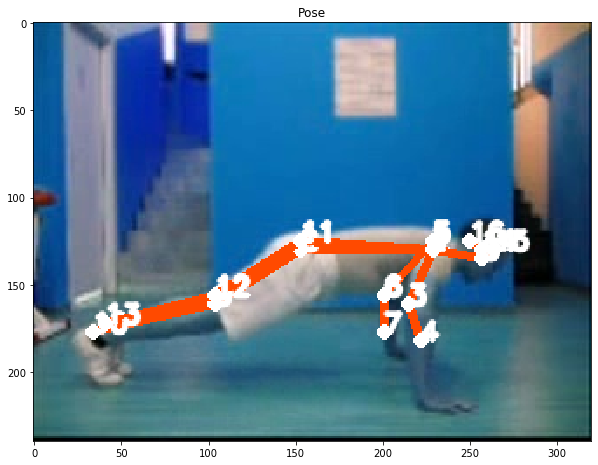

In [468]:
plt.figure(figsize=(10,10))
plt.imshow(testimg)
plt.title('Pose')
plt.show()

### Prepare training data

In [469]:
all_lbl = np.asarray(frames_n_labels['label'])
all_lbl = all_lbl.reshape(-1,1)
oh_lbl = LabelEncoder().fit_transform(all_lbl)
oh_lbl

D:\Anaconda3\envs\vse\lib\site-packages\sklearn\preprocessing\label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1])

In [470]:
# Train test split
trainData, testData, trainLabel, testLabel = train_test_split(netout_stk, oh_lbl, test_size=TEST_SIZE, random_state=42)

In [471]:
print(f'trainData shape: {trainData.shape}')
print(f'testData shape: {testData.shape}')
print(f'trainLabel shape: {trainLabel.shape}')
print(f'testLabel shape: {testLabel.shape}')

trainData shape: (71, 46, 46, 57)
testData shape: (18, 46, 46, 57)
trainLabel shape: (71,)
testLabel shape: (18,)


### Training Model

In [472]:
def createModel(x, y, features):
    ipt = Input(shape=(x, y, features))

    x   = Conv2D(32, (3,3), padding='same', strides=(2,2))(ipt)
    x   = BatchNormalization()(x)
    x   = Activation('relu')(x)
    
    x   = Conv2D(32, (3,3), padding='same', strides=(2,2))(x)
    x   = BatchNormalization()(x)
    x   = Activation('relu')(x)
    
    x   = Conv2D(64, (3,3), padding='same', strides=(2,2))(x)
    x   = BatchNormalization()(x)
    x   = Activation('relu')(x)
    
    x   = Conv2D(64, (3,3), padding='same', strides=(2,2))(x)
    x   = BatchNormalization()(x)
    x   = Activation('relu')(x)
    x   = Dropout(0.5)(x)
       
    x   = Flatten()(x)
    x   = Dense(128, activation='relu', kernel_initializer=he_normal(42), kernel_regularizer=l2(0.001))(x)
    x   = Dense(64, activation='relu', kernel_initializer=he_normal(42), kernel_regularizer=l2(0.001))(x)
    x   = Dense(1, activation='sigmoid')(x)
    
    model = Model(ipt, x)
    model.compile(loss='binary_crossentropy', 
                  optimizer='adam', 
                  metrics=['accuracy'])
    
    return model

In [473]:
xShape, yShape, featureShape = trainData[0].shape
trainModel = createModel(xShape, yShape, featureShape)
inferModel = createModel(xShape, yShape, featureShape)
trainModel.summary()

Model: "model_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_57 (InputLayer)        [(None, 46, 46, 57)]      0         
_________________________________________________________________
conv2d_172 (Conv2D)          (None, 23, 23, 32)        16448     
_________________________________________________________________
batch_normalization_194 (Bat (None, 23, 23, 32)        128       
_________________________________________________________________
activation_170 (Activation)  (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_173 (Conv2D)          (None, 12, 12, 32)        9248      
_________________________________________________________________
batch_normalization_195 (Bat (None, 12, 12, 32)        128       
_________________________________________________________________
activation_171 (Activation)  (None, 12, 12, 32)        0  

In [474]:
modelname = 'pose'
modelpath = os.path.join('Model', modelname+'.hdf5')
checkpoint = ModelCheckpoint(modelpath, 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min')
csv_logger = CSVLogger(modelname +'.csv')
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')
reduceLr = ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=1, mode='auto')

callbacks_list  = [checkpoint, csv_logger, early_stop, reduceLr]

In [475]:
trainModel.fit(x=trainData, y=trainLabel,
              batch_size=BATCH_SIZE,
              validation_data=(testData,testLabel),
              epochs=EPOCH,
              callbacks=callbacks_list)

Train on 71 samples, validate on 18 samples
Epoch 1/200
68/71 [===========================>..] - ETA: 0s - loss: 0.4383 - accuracy: 0.9559
Epoch 00001: val_loss improved from inf to 0.98728, saving model to Model\pose.hdf5
71/71 [==============================] - 2s 31ms/sample - loss: 0.4330 - accuracy: 0.9577 - val_loss: 0.9873 - val_accuracy: 0.7778
Epoch 2/200
70/71 [============================>.] - ETA: 0s - loss: 0.2924 - accuracy: 1.0000
Epoch 00002: val_loss improved from 0.98728 to 0.92306, saving model to Model\pose.hdf5
71/71 [==============================] - 0s 6ms/sample - loss: 0.2921 - accuracy: 1.0000 - val_loss: 0.9231 - val_accuracy: 1.0000
Epoch 3/200
60/71 [========================>.....] - ETA: 0s - loss: 0.2611 - accuracy: 1.0000
Epoch 00003: val_loss improved from 0.92306 to 0.86514, saving model to Model\pose.hdf5
71/71 [==============================] - 0s 6ms/sample - loss: 0.2590 - accuracy: 1.0000 - val_loss: 0.8651 - val_accuracy: 0.8889
Epoch 4/200
62/71

In [476]:
inferModel.load_weights(modelpath)
inferModel.compile(loss="binary_crossentropy", 
                  optimizer=optimizer,
                  metrics=["accuracy"])

In [477]:
pred = inferModel.predict(testData, batch_size=BATCH_SIZE)
predout = np.argmax(pred, axis=1)
# testout = np.argmax(testLabel, axis=1)

testScores = metrics.accuracy_score(testLabel, predout)
confusion  = metrics.confusion_matrix(testLabel, predout)

print("Best accuracy (on testing dataset): %.2f%%" % (testScores*100))
print(metrics.classification_report(testLabel,predout,target_names=labels,digits=4))
print(confusion)

Best accuracy (on testing dataset): 72.22%
              precision    recall  f1-score   support

     PushUps     0.7222    1.0000    0.8387        13
  NotPushUps     0.0000    0.0000    0.0000         5

    accuracy                         0.7222        18
   macro avg     0.3611    0.5000    0.4194        18
weighted avg     0.5216    0.7222    0.6057        18

[[13  0]
 [ 5  0]]


D:\Anaconda3\envs\vse\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


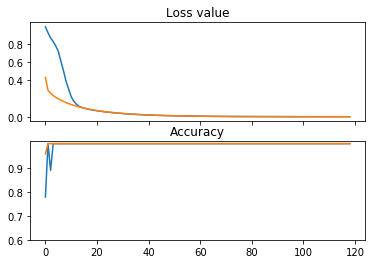

In [478]:
records = pd.read_csv(modelname +'.csv')
plt.figure()
plt.subplot(211)
plt.plot(records['val_loss'])
plt.plot(records['loss'])
plt.yticks([0.00,0.40,0.60,0.80])
plt.title('Loss value',fontsize=12)

ax = plt.gca()
ax.set_xticklabels([])

plt.subplot(212)
plt.plot(records['val_accuracy'])
plt.plot(records['accuracy'])
plt.yticks([0.6,0.7,0.8,0.9])
plt.title('Accuracy',fontsize=12)
plt.show()